<a id="top"></a>

<div style="display: flex; justify-content: space-between;">
    <a href="../notebook/01 - Business & Data Understanding.ipynb" style="float: left; padding: 10px; text-decoration: none; background-color: #007bff; color: white; border-radius: 5px;">Previous</a>
    <a href="../notebook/" style="float: right; padding: 10px; text-decoration: none; background-color: #007bff; color: white; border-radius: 5px;">Next</a>
</div>

In [1]:
# Importing necessary libraries
import warnings 
import numpy as np  
import pandas as pd 
import seaborn as sns   
import matplotlib.pyplot as plt 
import scipy.stats as stat

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Hide warning issues to prevent unnecessary output clutter
warnings.filterwarnings("ignore")

# Setting the maximum column width for pandas display to 100 characters
pd.options.display.max_colwidth = 100

# Applying the 'seaborn' style to matplotlib for consistent and visually appealing plots
plt.style.use('seaborn')   

# import sys
# sys.path.append('../scripts')
# from helper import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<a id="numerical"></a>
## <b><span style='color:darkturquoise'>Section 3 |</span><span style='color:darkblue'> Data Exploration</span></b>

____

As discussed earlier in Section 1, the ultimate goal is to address negative feedback and improve customer satisfaction. To this end, we first need to identify the characteristics and patterns associated with low ratings. This identification will shed light on the possible contributing factors to customer dissatisfaction and enable the Customer Experience Manager, as the key stakeholder of this project, to take necessary actions to enhance the Starbucks experience. This section explores the dataset by relating every feature (e.g., Rating, Review, Location) to customer sentiment, with a particular focus on understanding the drivers of low ratings. By analyzing these features and comparing them based on the rating levels (low vs high), we aim to gain insights into the aspects of the service or product that customers are dissatisfied with.

To make this section more structured, we divide Section 3 into three groups. Each group will focus on a different aspect of the dataset and be guided by specific questions to streamline the analysis.

1. **Distribution and Patterns of Ratings** focuses on general metrics, such as rating frequency, location-based differences, and time periods.
    
    - What is the overall distribution of customer ratings, and how prevalent are low ratings (e.g., 1 and 2 stars)?
    - Which locations have the highest concentration of low ratings, and are there regional patterns in customer dissatisfaction?
    - Are there correlations between lower ratings and specific time periods, such as holidays or promotions?

2. **Review Content and Engagement** addresses the textual and visual aspects of reviews and their relationship to customer ratings.

    - How often do customers include detailed reviews or images in their feedback?
    - Do low ratings correlate with the absence of images in reviews, suggesting potential gaps in review engagement?
    - What is the relationship between rating scores and review text length?
    - What are the most frequent themes or keywords in negative reviews, and how do they differ across locations?

3. **Temporal and Behavioral Trends** looks at the patterns of review submission over time, focusing on specific customer behaviors and location comparisons.

    - How does the frequency of negative reviews vary over time, and are there any noticeable trends or seasonal patterns?
    - Are certain customer groups (e.g., recurring reviewers) more likely to leave negative feedback compared to others?
    - How do top-rated locations differ from poorly rated ones in terms of review content (keywords or phrases), or rating over time, and what best practices can be adopted?

In [2]:
# Import the dataset from a CSV file into a pandas DataFrame
df = pd.read_csv('../data/data.csv')

<a id="basic"></a>
### <b><span style='color:darkblue'> 3.1 Data Preparation: Cleaning and Creating</span></b>

In this section, we perform a series of data preparation steps. The primary goal is to prepare the data for analyzing customer feedback and ratings for Starbucks. However, it is important to note that, as with general data analysis purposes, only basic data transformations were applied.

In [3]:
df = df[df.Review != 'No Review Text']

The first step is to remove any duplicate rows and impute missing values with the median. This ensures that each record is unique, preventing the influence of repeated information on the analysis. The median is chosen for imputation as it preserves the overall distribution of ratings and is less sensitive to extreme outliers compared to the mean.

In [4]:
# Drop duplicate rows in the dataframe to ensure data uniqueness
df.drop_duplicates(inplace=True)

# Fill missing 'Rating' values with the median value of the 'Rating' column
df.fillna({'Rating': df['Rating'].median()}, inplace=True)

The column `date` initially contained "Reviewed ..." and commas so prior to the object to datetime conversion, they were removed, , ensuring a consistent and accurate representation of review dates.

In [5]:
# Remove the prefix "Reviewed " and convert to datetime
df['Date'] = pd.to_datetime(df['Date'].str.replace('Reviewed ', '', regex=False))

This variable processes the `Review` column by removing non-alphabetic characters and converting the text to lowercase, which helps standardize the text for further analysis. It ensures that only relevant words are counted, providing a cleaner representation of the review's content for subsequent word count analysis.

In [6]:
# Clean text and process the DataFrame in a single step
df['Review'] = df['Review'].str.replace(r'[^a-zA-Z\s]', '', regex=True).str.lower()

This variable extracts the `State` from the location field, providing a clear representation of the geographical area associated with each review. It helps to capture the state-level context of the review by splitting the location string and selecting the last part after the comma.

In [7]:
# Extract the state abbreviation using split
df['State'] = df['location'].str.split(', ').str[-1]

This variable extracts the month and year from the 'Date' column, creating two new columns, 'Review_Month' and 'Review_Year'. This helps in identifying long-term trends (year) and seasonal patterns (month) in reviews by capturing when each review was submitted.

In [8]:
# Extract the month from the 'Date' column and create a new column 'Review_Month'
df['Review_Month'] = pd.to_datetime(df['Date'], errors='coerce').dt.month

# Extract the year from the 'Date' column and create a new column 'Review_Year'
df['Review_Year'] = pd.to_datetime(df['Date'], errors='coerce').dt.year

This variable calculates the `number of word` in each review, helping to better captures the expressiveness of a review since it reflects the level of detail provided.

In [9]:
# Calculate the word count for each review by splitting the text on spaces and counting the resulting words
df['Word_Count'] = df['Review'].apply(lambda x: len(str(x).split()))

This binary variable indicates whether a review `includes images (1) or not (0)`. It highlights the engagement level of the customer.

In [10]:
# Check if the review includes an image. If 'No Images' is found in 'Image_Links', assign 0, otherwise assign 1
df['Has_Image'] = df['Image_Links'].apply(lambda x: 0 if 'No Images' in x else 1)

In [11]:
# Define a function to categorize rating scores
def categorize_rating(score):
    if score <= 2:  # Low rating
        return 'Low'
    elif score == 3:  # Medium rating
        return 'Medium'
    else:  # High rating (4 or 5)
        return 'High'

# Apply the function to create a new column
df['Rating_Category'] = df['Rating'].apply(categorize_rating)

In [12]:
# Define a preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)             # Remove punctuation using a regular expression
    text = text.lower()                             # Convert all text to lowercase to ensure uniformity
    stop_words = set(stopwords.words('english'))    # Define a set of stopwords to remove common, non-informative words
    tokens = word_tokenize(text)                    # Tokenize the text into individual words
    tokens = [word for word in tokens if word not in stop_words]    # Remove stopwords from the tokens
    return ' '.join(tokens)

# Apply the function to create a new column
df['Review_Clean'] = df['Review'].apply(preprocess_text)

<a id="basic"></a>
### <b><span style='color:darkblue'> 3.2 Distribution and Patterns of Ratings Analysis</span></b>



#### **Q1. How are customer ratings distributed, and what is the proportion of low ratings (1-2 stars)?**

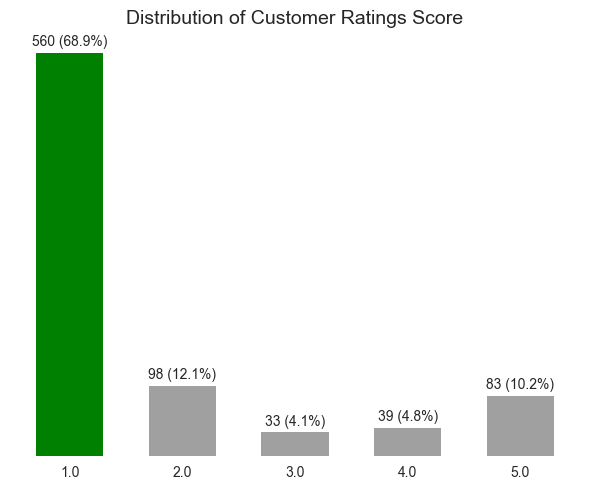

In [13]:
# Calculate rating distribution and percentages
rating_distribution = df['Rating'].value_counts().sort_index()  # Count of each rating
rating_percentage = df['Rating'].value_counts(normalize=True).sort_index() * 100  # Percentage of each rating

# Set colors: green for the most frequent rating, gray for others
max_rate_index = rating_distribution.idxmax()  # Index of the highest count
colors = ['#008000' if i == max_rate_index else '#A0A0A0' for i in rating_distribution.index]

# Create bar plot
fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(rating_distribution.index, rating_distribution.values, color=colors, width=0.6)

# Annotate bars with count and percentage
for bar, count, pct in zip(bars, rating_distribution.values, rating_percentage.values):
    ax.annotate(f'{count} ({pct:.1f}%)', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points", ha='center', fontsize=10)

# Customize plot appearance
ax.set_facecolor("none")
ax.get_yaxis().set_visible(False)
ax.set_title('Distribution of Customer Ratings Score', fontsize=14)
ax.set_xticks(rating_distribution.index)
ax.set_xticklabels(rating_distribution.index, fontsize=10)
ax.spines[['left', 'top', 'bottom', 'right']].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

**Key Takeaways**

The bar chart visualizes the overall distribution of customer ratings. Below is a detailed interpretation:
* **Predominance of Low Ratings:** The majority of customers gave a rating of 1 star, with 595 reviews, representing 70.1% of the total dataset. This overwhelming proportion suggests significant dissatisfaction among the customer base.
* **Moderate Dissatisfaction:** Ratings of 2 stars account for 99 reviews, or 11.7%. When combined with the 1-star reviews, it indicates that over 81.8% of the customers rated the service poorly (1 or 2 stars), reflecting pervasive negative sentiment.
* **Neutral to Positive Ratings:** Ratings of 3 stars (33 reviews, 3.9%) and 4 stars (39 reviews, 4.6%) are minimal, signaling a small segment of moderately satisfied customers. Ratings of 5 stars, representing 83 reviews (9.8%), show that a minor fraction of customers found the service or product exceptional.

The exceptionally high proportion of 1-star reviews underscores significant issues that demand immediate attention. In contrast, the noticeably low frequency of 4- and 5-star ratings indicates a lack of customer satisfaction and enthusiasm, which may hinder customer loyalty and negatively impact the brand's long-term reputation.

#### **Q2. Which locations have the highest concentration of low ratings, and are there regional patterns in customer dissatisfaction?**

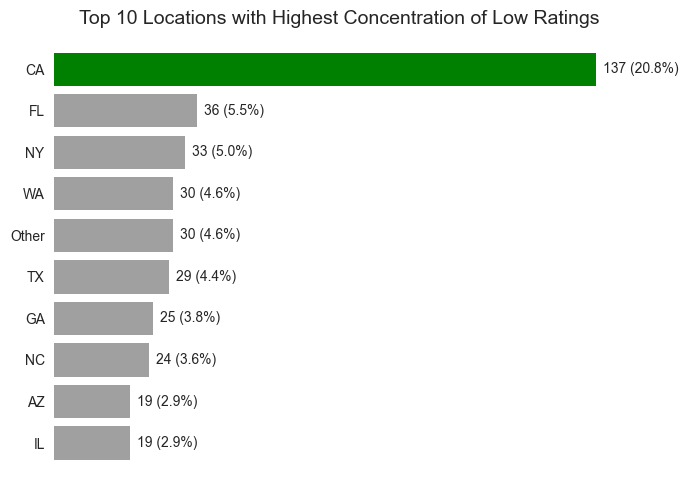

In [14]:
# Filter low ratings (1 and 2 stars)
low_ratings = df[df['Rating_Category'] == 'Low']

# Calculate the count and percentage of low ratings by location
low_rating_distribution = low_ratings['State'].value_counts()
low_rating_percentage = low_ratings['State'].value_counts(normalize=True) * 100

# Combine the count and percentage into a single DataFrame
location_summary = pd.DataFrame({
    'Low_Rating_Count': low_rating_distribution,
    'Low_Rating_Percentage': low_rating_percentage
}).sort_values(by='Low_Rating_Count', ascending=False)

# Select top 10 locations with the highest concentration of low ratings
top_locations = location_summary.head(10)

# Set colors: green for the most frequent rating, gray for others
max_rate_index = top_locations['Low_Rating_Count'].idxmax()  # Index of the highest count
colors = ['#008000' if i == max_rate_index else '#A0A0A0' for i in top_locations.index]

# Plot the top 10 locations
fig, ax = plt.subplots(figsize=(7, 5))
bars = ax.barh(top_locations.index, top_locations['Low_Rating_Count'], color=colors)

# Annotate the bars with count and percentage
for bar, count, pct in zip(bars, top_locations['Low_Rating_Count'], top_locations['Low_Rating_Percentage']):
    ax.annotate(f'{count} ({pct:.1f}%)', xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
                xytext=(5, 0), textcoords="offset points", va='center', fontsize=10)

# Customize plot appearance
ax.set_facecolor("none")
ax.set_title('Top 10 Locations with Highest Concentration of Low Ratings', fontsize=14)
ax.get_xaxis().set_visible(False)
ax.invert_yaxis()  # Invert y-axis for better readability
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

# Show
plt.tight_layout()
plt.show()

**Key Takeaways**

The bar chart provides insights into the distribution of "Low Rating" counts and their corresponding percentages across different states or regions. Below is a detailed interpretation of the data:

* CA (California) stands out with 144 low ratings, making up 20.75% of the total low ratings. This suggests that **California contributes the largest share of low ratings**, indicating either a larger user base or higher dissatisfaction in this state compared to others.
* **FL (Florida), WA (Washington), and NY (New York)** each report 33 low ratings, each accounting for 4.76% of the total low ratings. These states are somewhat similar in terms of low ratings, but they represent a relatively smaller proportion of the total when compared to California.
* **TX (Texas) and Other** both report 30 low ratings, representing 4.32% each. The numbers for TX and Other are comparable, highlighting that these states or regions also contribute modestly to the overall low rating count.
* **GA (Georgia) and NC (North Carolina)** each have 25 low ratings, which account for 3.60% each of the total. These states contribute slightly less to the overall low ratings than the others mentioned above, suggesting they either have a smaller population or lower dissatisfaction levels in comparison.
* **IL (Illinois) and NJ (New Jersey)** have the smallest count of low ratings, with 22 and 20 low ratings respectively, representing 3.17% and 2.88% of the total. These states show relatively lower dissatisfaction compared to other regions, suggesting either fewer issues or a higher level of overall satisfaction in these areas.

There is a clear concentration of low ratings in California, which may require immediate attention. Analyzing the reasons behind low ratings and implementing targeted strategies in high-concentration areas can help improve overall performance and customer satisfaction.

#### **Q3. How do review frequencies vary across different periods, and are there any noticeable seasonal or trend-based fluctuations?**

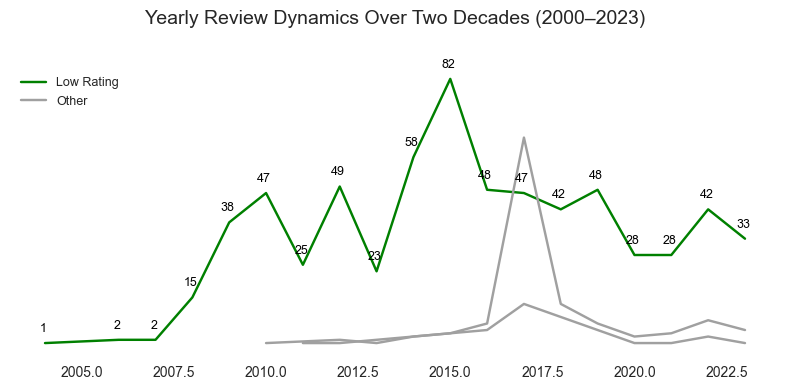

In [15]:
# Group by 'Review_Year' and 'Rating' to get monthly review counts
monthly_reviews = df.groupby(['Review_Year', 'Rating_Category']).size().reset_index(name='review_count')

# Create subplots for monthly trends (setting figure size)
fig, ax = plt.subplots(figsize=(8, 4))

# Plot yearly review frequencies using seaborn's lineplot
sns.lineplot(
    data=monthly_reviews,
    x='Review_Year',
    y='review_count',
    hue='Rating_Category',
    palette={'High': '#A0A0A0', 'Medium': '#A0A0A0', 'Low': '#008000'}
)

# Filter data for Rating 1 & 2, and add annotations
low_rating_data = monthly_reviews[monthly_reviews['Rating_Category'] == 'Low']
for i in range(len(low_rating_data)):
    ax.text(
        low_rating_data['Review_Year'].iloc[i] - .05, 
        low_rating_data['review_count'].iloc[i] + 2.5, 
        str(low_rating_data['review_count'].iloc[i]), 
        color='black', 
        ha='center', 
        va='bottom', 
        fontsize=9
    )

# Set title and other properties for the plot
ax.set_title('Yearly Review Dynamics Over Two Decades (2000–2023)', fontsize=14, pad=30)
ax.set_facecolor("none")
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')

# Get legend handles and labels, then update the legend with custom settings
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Low Rating', 'Other'], loc='upper left', title=None, ncol=1, fontsize=9, title_fontsize=9)

# Adjust layout to avoid overlap and ensure proper spacing
plt.tight_layout()

# Show the plot
plt.show()

**Key Takeaways**

The following is an interpretation of how the overall review frequency changes from year to year to detect long-term trends:

* From 2000 to 2005, review activity for both groups remained extremely low, suggesting limited customer feedback or engagement during this period. However, there was a gradual increase in review counts, with a slight indication of more consistent feedback patterns emerging by 2005.
* Between 2006 and 2010, reviews for Low Rating saw noticeable growth, culminating in a sharp peak of 52 reviews in 2009. This surge may signify growing customer engagement or heightened dissatisfaction with services or products during this time.
* The period between 2011 and 2015 presented contrasting dynamics for Low Rating. After experiencing a dip to 23 reviews in 2013, the count rose dramatically to a peak of 82 in 2015, the highest recorded in the dataset. Such fluctuations suggest periods of heightened customer dissatisfaction, possibly linked to specific operational or external factors.
* Moving into 2016–2020, review activity for Low Rating stabilized somewhat, with numbers fluctuating moderately between 42 and 48. This relative steadiness might indicate operational improvements or more consistent customer experiences, although persistent dissatisfaction was still evident.
* Finally, from 2021 to 2023, there was a marked decline in reviews for Low Rating, with counts dropping to 33 by the end of the period. This decline could signal a combination of improved customer satisfaction and reduced negative feedback or diminished customer engagement with the review process.

The analysis of review frequencies and trends reveals a clear distinction between the behavior of Low Rating reviews and those classified as Other scores. **Reviews with a Low Rating demonstrate significant volatility, marked by pronounced peaks and troughs that reflect fluctuating customer sentiments**. In contrast, reviews under Other scores exhibit much greater stability and appear sparse, with no discernible dominant trends across the timeline.

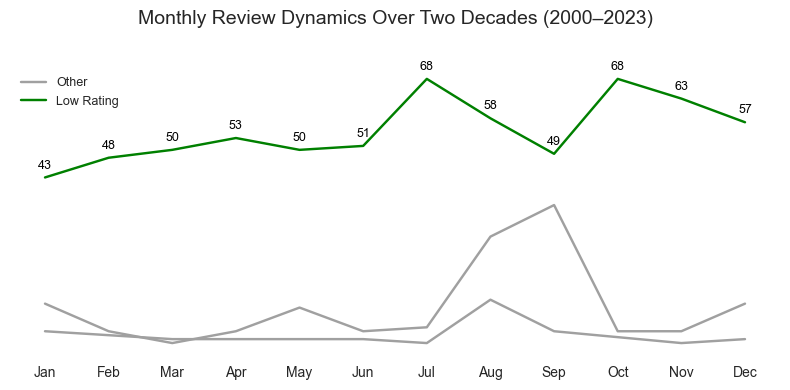

In [16]:
# Group by 'Review_Month' and 'Rating' to get monthly review counts
monthly_reviews = df.groupby(['Review_Month', 'Rating_Category']).size().reset_index(name='review_count')

# Mapping month names and ensuring the proper order
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_reviews['Review_Month'] = pd.Categorical(
    monthly_reviews['Review_Month'].apply(lambda x: month_names[x - 1]),
    categories=month_names,
    ordered=True
)

# Create subplots for monthly trends
fig, ax = plt.subplots(figsize=(8, 4))

# Plot monthly review frequencies
sns.lineplot(
    data=monthly_reviews,
    x='Review_Month',
    y='review_count',
    hue='Rating_Category',
    palette={'High': '#A0A0A0', 'Medium': '#A0A0A0', 'Low': '#008000'}
)

# Annotate values for rating 1 only
rating_1_data = monthly_reviews[monthly_reviews['Rating_Category'] == 'Low']
for i in range(len(rating_1_data)):
    ax.text(
        rating_1_data['Review_Month'].iloc[i], 
        rating_1_data['review_count'].iloc[i] + 1.5, 
        str(rating_1_data['review_count'].iloc[i]), 
        color='black', 
        ha='center', 
        va='bottom', 
        fontsize=9
    )

# Set title and other properties
ax.set_title('Monthly Review Dynamics Over Two Decades (2000–2023)', fontsize=14, pad=30)
ax.set_facecolor("none")
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xticklabels(month_names)

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Other', 'Low Rating'], title=None, ncol=1, fontsize=9, title_fontsize=9)

# Adjust layout
plt.tight_layout()
plt.show()

**Key Takeaways**

The following is an interpretation based on the period as well as any seasonal fluctuations or trends seen:

* The first half of the year (January–June) is relatively stable, with fewer fluctuations. Pronounced dips in January (48) and May (50) highlight periods of lower customer dissatisfaction.
* The third and fourth quarters show significant spikes in low-rating reviews, with a clear upward trajectory from June (52) to a peak in October (70). This trend suggests that dissatisfaction may rise during these months, potentially due to seasonal promotions, product launches, or increased customer interactions.
* Following the peak in October, the frequency slightly declines in November (70) and further in December (64). While still elevated, the reduction may indicate some mitigation in customer issues or reduced customer activity during year-end holidays.
* For "Other" reviews, their sparse and stable nature suggests limited engagement from neutral or satisfied customers. Encouraging more positive feedback through surveys or incentives could provide a balanced perspective on customer sentiment.

The review frequency shows a notable **increase during the third and fourth quarters**, with the consistent peak in October and November aligns with periods that may involve significant customer interactions. In contrast, the first half of the year **(January–June) is relatively quieter**, with pronounced dips in months like April and May.

#### **Q4. What are the main factors that contribute to low ratings? Is it more related to the product, service, price, or customer experience?**

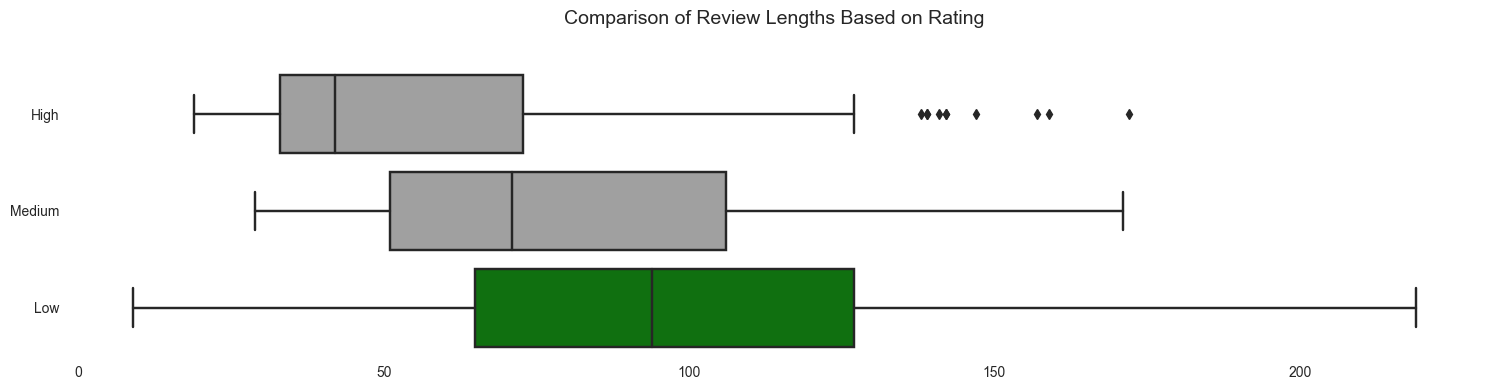

,count,mean,std,min,25%,50%,75%,max
Rating_Category,,,,,,,,
High,122.0,58.918033,36.641121,19.0,33.0,42.0,72.75,172.0
Low,658.0,96.741641,41.377611,9.0,65.0,94.0,127.00,219.0
Medium,33.0,82.727273,39.121823,29.0,51.0,71.0,106.00,171.0


In [17]:
# Setting the figure size for the plot
fig, ax = plt.subplots(figsize=(15, 4))

# Using seaborn to create a boxplot comparing review lengths (Word_Count) across different rating categories
sns.boxplot(
    x='Word_Count',
    y='Rating_Category',
    data=df,
    order=['High', 'Medium', 'Low'],
    palette={'High': '#A0A0A0', 'Medium': '#A0A0A0', 'Low': '#008000'}
)

# Adding a title to the plot with a specific font size and padding
ax.set_title('Comparison of Review Lengths Based on Rating', fontsize=14, pad=30)

# Setting the plot background to transparent
ax.set_facecolor("none")

# Removing labels for the x-axis and y-axis
ax.set_xlabel('')
ax.set_ylabel('')

# Adjusting layout to avoid overlapping elements
plt.tight_layout()

# Displaying the plot
plt.show()

# Grouping data by Rating_Category and displaying descriptive statistics for Word_Count
df.groupby('Rating_Category')['Word_Count'].describe()

**Key Takeaways**

The boxplot and descriptive statistics reveal the following themes related to low-rated reviews based on textual characteristics, specifically focusing on review length (Word_Count):

* High-rated reviews exhibit a greater number of outliers on the longer end of the word count. This suggests that while most high-rated reviews are concise, a minority include detailed elaborations.
* Low-rated reviews have the highest mean word count of 91.88, significantly higher than high-rated (58.92) and medium-rated (82.73) reviews. **The distribution for low-rated reviews is notably more spread out**, with a maximum word count of 219 and a third quartile (75%) of 125, **indicating that these reviews are often detailed and lengthy.** Some users opt for short, sharp complaints, expressing their dissatisfaction concisely with phrases like "Terrible experience" or "Not worth it." These reviews are direct and highlight frustration without elaboration. On the other hand, there are users who provide long, detailed complaints, offering comprehensive accounts of their negative experiences. These reviews often include specific reasons for their dissatisfaction, such as unmet expectations, poor service, or product defects, and reflect a deeper emotional investment in articulating their grievances.
* The interquartile range (IQR) for low-rated reviews is larger compared to high and medium-rated reviews, reflecting more variability in how users express dissatisfaction.
Medium-rated reviews have slightly shorter word counts than low-rated reviews, but the difference suggests these reviews are still longer than high-rated reviews.

Low-rated reviews tend to be more detailed and lengthy, signaling a stronger emotional response and desire to provide actionable feedback. These characteristics provide a valuable opportunity for identifying and addressing critical pain points in the customer experience.

In [75]:
# Extract only the reviews categorized as "Low" from the dataset
low_rated_reviews = df[df['Rating_Category'] == 'Low']['Review_Clean']

# Initialize the TF-IDF vectorizer with a maximum of 20 keywords
tfidf_vectorizer = TfidfVectorizer(max_features=20)
tfidf_matrix = tfidf_vectorizer.fit_transform(low_rated_reviews)
keywords = tfidf_vectorizer.get_feature_names_out()

# Initialize the LDA model with 3 topics and a random seed for reproducibility
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_matrix = lda.fit_transform(tfidf_matrix)

# Assign the most likely topic to each review
low_rated_reviews = low_rated_reviews.to_frame()
low_rated_reviews['Topic'] = lda_matrix.argmax(axis=1)

# Loop through each topic to extract and display the top 20 keywords
for topic_idx, topic in enumerate(lda.components_):
    topic_keywords = [keywords[i] for i in topic.argsort()[::-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(topic_keywords)}")

Topic 1: drink, said, asked, like, starbucks, ordered, get, went, time, order, told, go, coffee, store, one, would, customer, back, service, card
Topic 2: store, customer, service, starbucks, order, get, coffee, go, one, told, drink, back, like, went, would, ordered, asked, said, time, card
Topic 3: card, starbucks, told, customer, would, service, went, one, asked, said, store, get, back, go, drink, coffee, time, like, ordered, order
Topic 4: coffee, starbucks, one, ordered, go, would, like, went, time, asked, drink, get, order, told, store, back, said, customer, service, card
Topic 5: time, back, would, starbucks, get, customer, service, order, went, one, go, like, told, asked, ordered, coffee, drink, store, said, card


**Key Takeaways**

The results of the LDA topic modeling reveal distinct themes emerging from the low-rated reviews of Starbucks. Below is a detailed interpretation of each topic:

* **Topic 1: Issues with Customer Service and Cards.** This topic highlights complaints related to customer service and issues involving Starbucks gift cards. Keywords like "card," "customer," "service," and "called" suggest dissatisfaction with the resolution of problems or delays in addressing concerns. The frequent use of "told" and "would" may indicate promises made by the company that were not fulfilled.
* **Topic 2: Store Experience and Coffee Quality.** This topic focuses on the in-store experience and product quality, particularly coffee. Words such as "store," "cup," "get," and "went" indicate dissatisfaction with the coffee itself, as well as the overall experience at specific locations. The inclusion of "im" and "said" suggests direct feedback or recounting of conversations with staff.
* **Topic 3: Problems with Orders and Staff.** This topic centers on problems related to ordering and the preparation of drinks. Keywords like "drinks," "drink," "manager," "make," and "order" highlight frustrations with incorrectly made orders, delays, or perceived inefficiencies in the staff's handling of orders. Complaints may also involve interactions with managers or staff behavior.
* **Topic 4: Negative Interactions and Time Management.** This topic suggests issues with how time is managed during visits and negative interactions with employees. Keywords such as "got," "time," "asked," and "back" point to dissatisfaction with wait times or incomplete orders. Words like "said" and "could" may reflect attempts to negotiate or resolve issues that were unsuccessful.
* **Topic 5: Long-Term Dissatisfaction and Employee Behavior.** This topic reflects long-term dissatisfaction with Starbucks locations and staff behavior. Words like "years," "never," "employees," and "location" suggest consistent negative experiences over time. Keywords such as "morning" and "time" might imply dissatisfaction during busy times or frequent visits.

These themes suggest that low-rated reviews often stem from a combination of poor service, inconsistent product quality, and negative interactions with staff, which collectively contribute to customers' dissatisfaction.

In [115]:
low_rated_reviews.Topic.value_counts(normalize=True)

1    0.260807
2    0.223343
0    0.206052
3    0.161383
4    0.148415
Name: Topic, dtype: float64

#### **Q5. Is there a relationship between certain locations and specific types of complaints? (For example, poor service is more commonly reported in big cities, while quality issues are more prevalent in suburban areas?)**

Soon

#### **Q6. Does the presence or absence of specific multimedia content (e.g., images) correlate with ratings, and does it indicate differences in review engagement?**

Soon

<a href="#top" style="display: inline-block; padding: 10px; text-decoration: none; background-color: #007bff; color: white; border-radius: 5px; margin-top: 20px;">Back to Top</a>